In [1]:
%matplotlib inline



In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

from loren_frank_data_processing import (make_epochs_dataframe,make_neuron_dataframe)
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)
from src.load_data import get_sleep_and_prev_run_epochs
from ZilongCode.utils import get_sweep_awake_and_sleep_replay_results

In [3]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]

n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)

# select only sleep epochs
is_sleep = (epoch_info.type.isin(['sleep']))

is_animal = epoch_info.index.isin(['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha'], level='animal')

#get valid epochs with is_sleep and is_animal and n_neurons > MIN_N_NEURONS
valid_epochs =  epoch_info.loc[is_sleep & 
                                is_animal & 
                                (epoch_info.n_neurons > MIN_N_NEURONS)]

sleep_epoch_keys, prev_run_epoch_keys = get_sleep_and_prev_run_epochs()

# get valid sleep epochs with keys only in sleep_epoch_keys
valid_sleep_epochs = valid_epochs.loc[valid_epochs.index.isin(sleep_epoch_keys)]

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']


In [4]:
all_sweep_len_peranimal = {}; all_sweep_len_perday = {}
all_awake_exponent_peranimal = {}; all_awake_exponent_perday = {}
all_sleep_exponent_peranimal = {}; all_sleep_exponent_perday = {}

for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs =  epoch_info.loc[is_sleep & 
                                   is_animal & 
                                   (epoch_info.n_neurons > MIN_N_NEURONS)]

    valid_sleep_epochs = valid_epochs.loc[valid_epochs.index.isin(sleep_epoch_keys)]
    
    sweep_amp = []
    awake_exponent = []
    sleep_exponent = []
    for sleep_epoch_key in tqdm(valid_sleep_epochs.index, desc='epochs'):
        
        #get previous run epoch key
        prev_run_epoch_key = prev_run_epoch_keys[sleep_epoch_keys.index(sleep_epoch_key)]
        animal_run, day_run, epoch_run = prev_run_epoch_key
        animal_sleep, day_sleep, epoch_sleep = sleep_epoch_key
        
        #skip 'egy', 10, 2 since no mental_distance_from_actual_position is saved (double check later)
        if (animal_run, day_run, epoch_run ) == ('egy', 10, 2):
            continue

        if (animal_run, day_run, epoch_run ) == ('dud', 6, 4):
            continue
        
        sleep_result = os.path.join(
            DATA_DIR,
            "TrueSleepReplayTrajectories",
            (f"{animal_sleep}_{day_sleep:02d}_{epoch_sleep:02d}_traj.pkl"),
            )  
        #if sleep_result does not exist, skip
        if not os.path.exists(sleep_result):
            continue

        print(f'Animal: {animal_run}, Day: {day_run}, Epoch: {epoch_run}')
        
        #get the average sweep length and replay exponent
        results = get_sweep_awake_and_sleep_replay_results(prev_run_epoch_key, sleep_epoch_key, DATA_DIR, sweep_speed_threshold=4)
        
        [mean_sweep_amp, 
         awake_replay_exponent, 
         sleep_replay_exponent] = results
        
        #print the average sweep length and replay exponent in one line, keep three decimal places
        print(f'Average sweep length: {mean_sweep_amp:.3f}, Awake Diffusion exponent: {awake_replay_exponent:.3f}, Sleep Diffusion exponent: {sleep_replay_exponent:.3f}')
        
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_sweep_len_perday.setdefault((animal_run, day_run), []).append(mean_sweep_amp)
        all_awake_exponent_perday.setdefault((animal_run, day_run), []).append(awake_replay_exponent)
        all_sleep_exponent_perday.setdefault((animal_run, day_run), []).append(sleep_replay_exponent)
        
        sweep_amp.append(mean_sweep_amp)
        awake_exponent.append(awake_replay_exponent)
        sleep_exponent.append(sleep_replay_exponent)
    
    all_sweep_len_peranimal[name] = sweep_amp
    all_awake_exponent_peranimal[name] = awake_exponent
    all_sleep_exponent_peranimal[name] = sleep_exponent

epochs:   0%|          | 0/23 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2
Average sweep length: 49.932, Awake Diffusion exponent: 0.836, Sleep Diffusion exponent: 0.651
Animal: bon, Day: 3, Epoch: 4
Average sweep length: 34.348, Awake Diffusion exponent: 0.840, Sleep Diffusion exponent: 0.517
Animal: bon, Day: 3, Epoch: 6
Average sweep length: 43.452, Awake Diffusion exponent: 0.476, Sleep Diffusion exponent: 0.525
Animal: bon, Day: 4, Epoch: 4
Average sweep length: 35.363, Awake Diffusion exponent: 0.759, Sleep Diffusion exponent: 0.955
Animal: bon, Day: 4, Epoch: 6
Average sweep length: 44.658, Awake Diffusion exponent: 0.643, Sleep Diffusion exponent: 0.690
Animal: bon, Day: 5, Epoch: 2
Average sweep length: 33.390, Awake Diffusion exponent: 0.751, Sleep Diffusion exponent: 0.572
Animal: bon, Day: 5, Epoch: 4
Average sweep length: 31.837, Awake Diffusion exponent: 0.756, Sleep Diffusion exponent: 0.556
Animal: bon, Day: 6, Epoch: 2
Average sweep length: 36.235, Awake Diffusion exponent: 0.748, Sleep Diffusion exponent: 0.542


epochs:   0%|          | 0/27 [00:00<?, ?it/s]

Animal: fra, Day: 6, Epoch: 6
Average sweep length: 33.698, Awake Diffusion exponent: 0.559, Sleep Diffusion exponent: 0.629


epochs:   0%|          | 0/17 [00:00<?, ?it/s]

Animal: gov, Day: 7, Epoch: 4
Average sweep length: 45.809, Awake Diffusion exponent: 0.771, Sleep Diffusion exponent: 0.855
Animal: gov, Day: 8, Epoch: 4
Average sweep length: 47.207, Awake Diffusion exponent: 0.810, Sleep Diffusion exponent: 0.771
Animal: gov, Day: 8, Epoch: 6
Average sweep length: 52.232, Awake Diffusion exponent: 0.662, Sleep Diffusion exponent: 0.703
Animal: gov, Day: 9, Epoch: 5
Average sweep length: 51.276, Awake Diffusion exponent: 0.789, Sleep Diffusion exponent: 0.683
Animal: gov, Day: 11, Epoch: 4
Average sweep length: 56.690, Awake Diffusion exponent: 0.816, Sleep Diffusion exponent: 0.852
Animal: gov, Day: 12, Epoch: 6
Average sweep length: 47.958, Awake Diffusion exponent: 0.775, Sleep Diffusion exponent: 0.792
Animal: gov, Day: 13, Epoch: 6
Average sweep length: 52.889, Awake Diffusion exponent: 0.846, Sleep Diffusion exponent: 0.817


epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Animal: dud, Day: 2, Epoch: 2
Average sweep length: 59.189, Awake Diffusion exponent: 0.792, Sleep Diffusion exponent: 0.718


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: con, Day: 1, Epoch: 4
Average sweep length: 46.733, Awake Diffusion exponent: 0.903, Sleep Diffusion exponent: 0.804
Animal: con, Day: 2, Epoch: 2
Average sweep length: 46.062, Awake Diffusion exponent: 1.084, Sleep Diffusion exponent: 0.618
Animal: con, Day: 2, Epoch: 4
Average sweep length: 47.894, Awake Diffusion exponent: 0.931, Sleep Diffusion exponent: 0.627
Animal: con, Day: 3, Epoch: 2
Average sweep length: 44.551, Awake Diffusion exponent: 0.955, Sleep Diffusion exponent: 0.929
Animal: con, Day: 3, Epoch: 4
Average sweep length: 43.777, Awake Diffusion exponent: 0.953, Sleep Diffusion exponent: 0.754
Animal: con, Day: 4, Epoch: 6
Average sweep length: 41.295, Awake Diffusion exponent: 0.602, Sleep Diffusion exponent: 0.761
Animal: con, Day: 5, Epoch: 2
Average sweep length: 41.453, Awake Diffusion exponent: 0.914, Sleep Diffusion exponent: 0.612
Animal: con, Day: 6, Epoch: 2
Average sweep length: 48.002, Awake Diffusion exponent: 0.519, Sleep Diffusion exponent: 0.621


epochs:   0%|          | 0/7 [00:00<?, ?it/s]

Animal: dav, Day: 3, Epoch: 6
Average sweep length: 53.330, Awake Diffusion exponent: 0.865, Sleep Diffusion exponent: 0.854
Animal: dav, Day: 4, Epoch: 2
Average sweep length: 57.930, Awake Diffusion exponent: 0.811, Sleep Diffusion exponent: 0.875
Animal: dav, Day: 4, Epoch: 4
Average sweep length: 42.085, Awake Diffusion exponent: 0.860, Sleep Diffusion exponent: 0.809
Animal: dav, Day: 6, Epoch: 2
Average sweep length: 49.210, Awake Diffusion exponent: 0.781, Sleep Diffusion exponent: 0.866
Animal: dav, Day: 6, Epoch: 4
Average sweep length: 42.176, Awake Diffusion exponent: 0.911, Sleep Diffusion exponent: 0.837
Animal: dav, Day: 6, Epoch: 6
Average sweep length: 46.240, Awake Diffusion exponent: 0.752, Sleep Diffusion exponent: 0.812


epochs:   0%|          | 0/12 [00:00<?, ?it/s]

Animal: Cor, Day: 1, Epoch: 4
Average sweep length: 51.277, Awake Diffusion exponent: 0.863, Sleep Diffusion exponent: 0.615
Animal: Cor, Day: 2, Epoch: 2
Average sweep length: 56.062, Awake Diffusion exponent: 0.774, Sleep Diffusion exponent: 0.583
Animal: Cor, Day: 2, Epoch: 4
Average sweep length: 52.966, Awake Diffusion exponent: 0.703, Sleep Diffusion exponent: 0.567
Animal: Cor, Day: 3, Epoch: 4
Average sweep length: 48.516, Awake Diffusion exponent: 0.816, Sleep Diffusion exponent: 0.612
Animal: Cor, Day: 4, Epoch: 4
Average sweep length: 75.751, Awake Diffusion exponent: 0.780, Sleep Diffusion exponent: 0.793
Animal: Cor, Day: 7, Epoch: 2
Average sweep length: 44.921, Awake Diffusion exponent: 0.807, Sleep Diffusion exponent: 0.614


epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Animal: egy, Day: 5, Epoch: 2
Average sweep length: 55.842, Awake Diffusion exponent: 0.800, Sleep Diffusion exponent: 0.776
Animal: egy, Day: 5, Epoch: 4
Average sweep length: 53.198, Awake Diffusion exponent: 0.868, Sleep Diffusion exponent: 0.701
Animal: egy, Day: 5, Epoch: 6
Average sweep length: 51.894, Awake Diffusion exponent: 0.730, Sleep Diffusion exponent: 0.686
Animal: egy, Day: 8, Epoch: 4
Average sweep length: 54.728, Awake Diffusion exponent: 0.775, Sleep Diffusion exponent: 0.739


epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Animal: cha, Day: 4, Epoch: 2
Average sweep length: 56.508, Awake Diffusion exponent: 0.727, Sleep Diffusion exponent: 0.856


In [12]:
all_sweep_len_perday_ave = {}
all_awake_exponent_perday_ave = {}
all_sleep_exponent_perday_ave = {}
for key in all_sweep_len_perday.keys():
    all_sweep_len_perday_ave[key] = np.mean(all_sweep_len_perday[key])
    all_awake_exponent_perday_ave[key] = np.mean(all_awake_exponent_perday[key])
    all_sleep_exponent_perday_ave[key] = np.mean(all_sleep_exponent_perday[key])
    
#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_sweep_len_perday_concat = {}
all_awake_exponent_perday_concat = {}
all_sleep_exponent_perday_concat = {}
for key in all_sweep_len_perday.keys():
    all_sweep_len_perday_concat.setdefault(key[0], []).append(all_sweep_len_perday_ave[key])
    all_awake_exponent_perday_concat.setdefault(key[0], []).append(all_awake_exponent_perday_ave[key])
    all_sleep_exponent_perday_concat.setdefault(key[0], []).append(all_sleep_exponent_perday_ave[key])


awake 0.3516933067601464 0.04839352395894474 0.12368818201988685 32
sleep 0.4857932692978646 0.0048220529895440685 0.23599510049510752 32


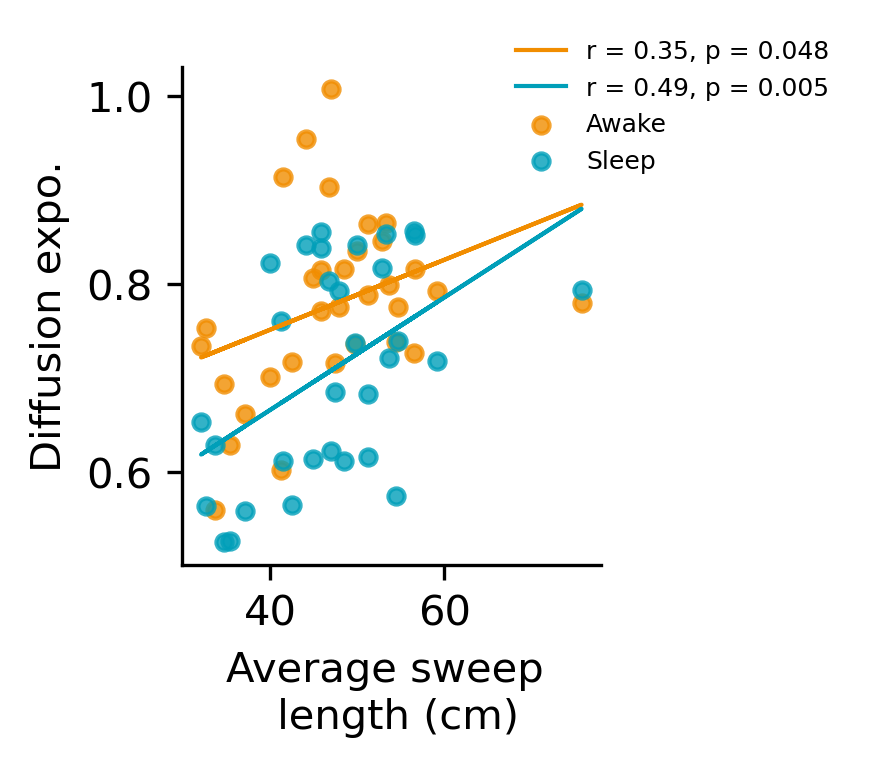

In [30]:

plt.figure(figsize=(1.8,2.2), dpi=300)
plt.subplot(1,1,1)
#top and right spine off
ax = plt.gca()
labelsize=8
ticksize=6

exp_np = np.concatenate(list(all_awake_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
#plot awake_exponent_perday_concat against awake_sweep_amp_perday_concat
plt.scatter(sweep_len_np, 
            exp_np,
            s=15, alpha=0.8, color='#F18D00', label='Awake')
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_awake_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
#calculate R square of the linear fit between sweep_len_np and exp_np
exp_np_true = exp_np
exp_np_pred = sweep_len_np * slope + intercept
r2 = r2_score(exp_np_true, exp_np_pred)
print('awake', corr, p, r2, len(exp_np))
ax.plot(sweep_len_np, sweep_len_np * slope + intercept, "#F18D00", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)




#plot sleep_exponent_perday_concat against sleep_sweep_len_perday_concat
exp_np = np.concatenate(list(all_sleep_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
plt.scatter(sweep_len_np, 
            exp_np, 
            s=15, alpha=0.8, color='#009FB9', label='Sleep')
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array

slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
#calculate R square of the linear fit between sweep_len_np and exp_np
exp_np_true = exp_np
exp_np_pred = sweep_len_np * slope + intercept
r2 = r2_score(exp_np_true, exp_np_pred)
print('sleep', corr, p, r2, len(exp_np))
ax.plot(sweep_len_np, sweep_len_np * slope + intercept, "#009FB9", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)
#pearson test
ax.set_xlabel('Average sweep \n length (cm)')
ax.set_ylabel('Diffusion expo.')

# ax.set_xticks([40,60])
# ax.set_xlim([30,65])
#top and right spine off
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#legend
ax.legend(loc='upper right', fontsize=6, frameon=False, bbox_to_anchor=(1.6, 1.1))
    

awake 0.2508623477499453 0.07284113848581572 0.06293191751861438 52
sleep 0.48108895760429266 0.0003058559717464609 0.23144658512878502 52


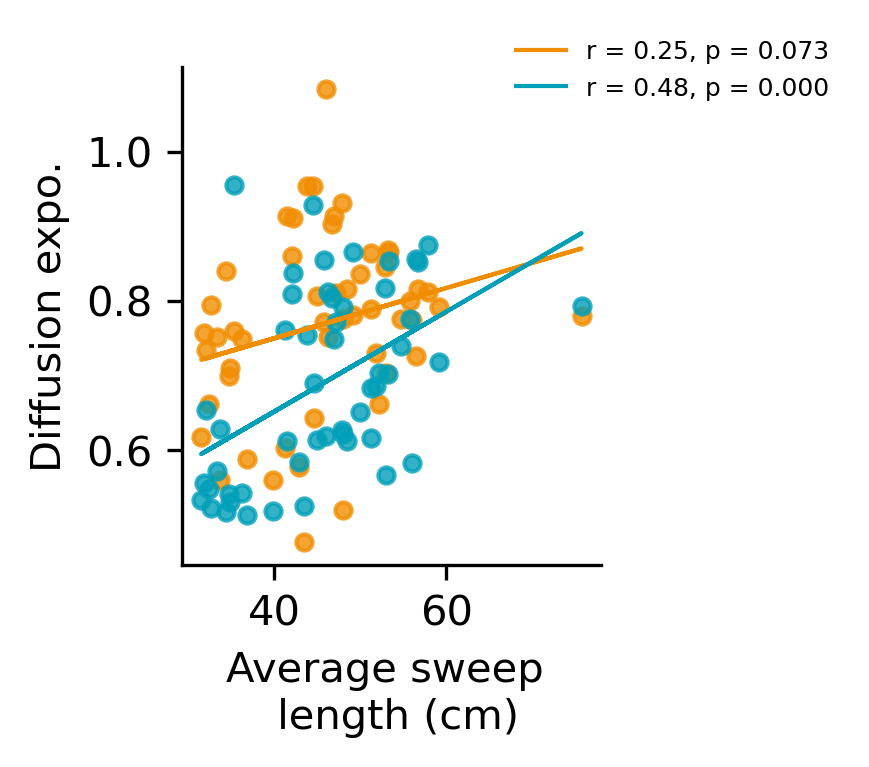

In [29]:
plt.figure(figsize=(1.8,2.2), dpi=300)
plt.subplot(1,1,1)
#top and right spine off
ax = plt.gca()
labelsize=8
ticksize=6

exp_np = np.concatenate(list(all_awake_exponent_peranimal.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_peranimal.values()))
#plot awake_exponent_perday_concat against awake_sweep_amp_perday_concat
plt.scatter(sweep_len_np, 
            exp_np,
            s=15, alpha=0.8, color='#F18D00')   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_awake_exponent_peranimal.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_peranimal.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
#calculate R square of the linear fit between sweep_len_np and exp_np
exp_np_true = exp_np
exp_np_pred = sweep_len_np * slope + intercept
r2 = r2_score(exp_np_true, exp_np_pred)
print('awake', corr, p, r2, len(exp_np))
ax.plot(sweep_len_np, sweep_len_np * slope + intercept, "#F18D00", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)


#plot sleep_exponent_perday_concat against sleep_sweep_len_perday_concat
exp_np = np.concatenate(list(all_sleep_exponent_peranimal.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_peranimal.values()))
plt.scatter(sweep_len_np, 
            exp_np, 
            s=15, alpha=0.8, color='#009FB9')
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array

slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
exp_np_true = exp_np
exp_np_pred = sweep_len_np * slope + intercept
r2 = r2_score(exp_np_true, exp_np_pred)
print('sleep', corr, p, r2, len(exp_np))
ax.plot(sweep_len_np, sweep_len_np * slope + intercept, "#009FB9", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)
#pearson test
ax.set_xlabel('Average sweep \n length (cm)')
ax.set_ylabel('Diffusion expo.')

# ax.set_xticks([40,60])
# ax.set_xlim([30,65])

#top and right spine off
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#legend 
ax.legend(loc='upper right', fontsize=6, frameon=False, bbox_to_anchor=(1.6, 1.1))
    